In [8]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_tuner.applications import HyperResNet, HyperEfficientNet, HyperXception


from audio_student import AudioUtil, Feature_vector_DS
from model_utils import *
from CNN_utils import *
#from classification.Q2.audio_student import AudioUtil, Feature_vector_DS
#from classification.Q1.model_utils import *
#from classification.Q2.CNN_utils import AudioUtil, Feature_vector_DS


"""
#Pipeline
#-------------------------
1. Dataset import -> get-dataset_matrix()
3. Data preparation -> get_dataset_()
2. Data split -> train_test_split()
3. Data scaling -> StandardScaler()
4. Data processing -> PCA?
5. Modelling -> Tensorflow CNNs (HyperEfficientNet, HyperResNet, HyperDenseNet, 
                HyperXception, HyperMobileNet), self-made)
6. Training and 7. Evaluation -> Tensorflow Keras tuner
8. Final_model -> perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report
#-------------------------

Wanted to use sklearn pipeline but seems too restrictive compared to the benefits
"""
verbose = True


### 1. + 3. + 4. dataset import & preparation & processing

TO MODIFY:
 - All soundfiles must be recorded by the MCU
 - The function Feature_vector_DS must be replaced by the functions in the MCU (in C), it sould have the list of hyperparameters as an input
 - Data augmentation: add background noise augmentation (function already exists!)
  - Potentially concatenate all file from the same class then apply shifting?
 - Conditional normalisation if classes are concatenated?
 - Add possibility to visualize the dataset

Processing: creation of FV from dataset
- Potential PCA
- Time duration


In [9]:
import time

def get_dataset(Nft=512, nmel=20, duration=950, normalize=True, shift_pct=0, img_idx = 0, verbose=False, play_sound = False):
    """
    Load and initialize the dataset with necessary attributes.
    """

    # Dataset class containing all sound files
    dataset = Dataset(folder="../datasets/sounds/Q2_sounds/")
    classnames = dataset.list_classes()
    if verbose:
        print("Classes in dataset: ", classnames)
        print("Number of elements in each class: ", dataset.naudio)
        print("Number of sounds in dataset: ", len(dataset))

    myds = Feature_vector_DS(dataset, Nft=Nft, nmel=nmel, duration=duration, shift_pct=shift_pct, normalize=normalize)
    myds.data_aug = None  # Ensure no augmentation initially

    if verbose:
        fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))
        for i, ax in zip(range(len(classnames)), axs):
            #play the sound using display()
            ax.imshow(myds[classnames[i], img_idx].reshape((nmel, -1)), cmap="jet", origin="lower", aspect="auto")
            ax.set_title(classnames[i])
            ax.set_xlabel("")
            ax.set_ylabel("Mel bins")
        plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
        plt.show()
    if play_sound:
        for i in range(len(classnames)):
            myds.display([classnames[i], img_idx])
            time.sleep(duration/1000)
    
    return myds, dataset, classnames

def augment_dataset(myds, dataset, classnames, augmentations, bg_dataset, nmel=20,  duration=950,
                    bg_amplitude_limit=[0.1], shift_nb = 1, noise_sigma=0.01, scaling_limit=5 ,
                    load_matrix = False, verbose=False, img_idx=0, aug_indexes = [0], play_sound=False,pickle_name = "feature_matrix_2D_aug.npy"):
    """
    Augment dataset and compute feature matrix.
    """
    train_pct = 1
    featveclen = len(myds["gun", 0])  # Number of items in a feature vector
    nitems = len(myds)  # Number of sounds in dataset
    naudio = dataset.naudio  # Number of audio files per class
    nclass = dataset.nclass  # Number of classes
    nlearn = round(naudio * train_pct)  # Training sample count

    myds.data_aug = None  # Ensure no augmentation initially
    data_aug_factor = len(augmentations)
    myds.data_aug_factor = data_aug_factor
    #myds.mod_data_aug(augmentations)


    
    myds.bg_dataset = bg_dataset
    myds.bg_amplitude_limit = bg_amplitude_limit
    myds.noise_sigma = noise_sigma
    myds.scaling_limit = scaling_limit
    myds.duration = duration


    if load_matrix:
        X_aug = np.load(pickle_name, allow_pickle=True)
        y_aug = np.load(pickle_name, allow_pickle=True)

    else:
        start_time = time.time()
        X_aug = np.zeros((nclass * naudio  + shift_nb * nclass * naudio +  len(bg_amplitude_limit) * nclass * naudio, featveclen))
        y_aug = np.empty((nclass * naudio  + shift_nb * nclass * naudio +  len(bg_amplitude_limit) * nclass * naudio,), dtype=object)
        print("Number of shifts: ", shift_nb)
        print("Number of bg_amplitude_limit and values: ", len(bg_amplitude_limit), bg_amplitude_limit)
        print("X_aug shape: ", X_aug.shape)

        #original dataset
        for idx in range(naudio):
            for class_idx, classname in enumerate(classnames):
                try:
                    featvec = myds[classname, idx]
                    X_aug[class_idx * naudio + idx, :] = featvec
                    y_aug[class_idx * naudio + idx] = classname
                except:
                    print(f"Error at {classname}, {idx}")
                    continue
        
        
        # Individual augmentations
        if len(augmentations) != 0:
            for current_aug in augmentations:
                myds.data_aug = current_aug
                print(f"Augmenting with {current_aug}")

                if current_aug == "time_shift":
                    myds.data_aug = "time_shift"

                    for j in range(0,shift_nb):
                        print("Shift number: ", j)
                        myds.shift_pct = np.random.uniform(-1, 1)
                        for idx in range(dataset.naudio):
                            print(f"%d/%d" % (idx, dataset.naudio))
                            for class_idx, classname in enumerate(classnames):
                                #print(classname, idx)
                                featvec = myds[classname, idx]
                                #print((s+1) * nclass * naudio + j * nclass * naudio + class_idx * naudio + idx)
                                X_aug[nclass * naudio + j * nclass * naudio + class_idx * naudio + idx, :] = featvec
                                y_aug[nclass * naudio + j * nclass * naudio + class_idx * naudio + idx] = classname

                elif current_aug == "add_bg":
                    myds.data_aug = "add_bg"

                    for j in range(0,len(bg_amplitude_limit)):
                        print("Background number: ", j)
                        myds.bg_amplitude_limit = bg_amplitude_limit[j]
                        for idx in range(dataset.naudio):
                            print(f"%d/%d" % (idx, dataset.naudio))
                            for class_idx, classname in enumerate(classnames):
                                #print(classname, idx)
                                featvec = myds[classname, idx]
                                #print(nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass + class_idx * naudio + idx)
                                X_aug[nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass + class_idx * naudio + idx, :] = featvec
                                y_aug[nclass * naudio + shift_nb * nclass * naudio + j * naudio * nclass+ class_idx * naudio + idx] = classname
                else:
                    for idx in range(dataset.naudio):
                        for class_idx, classname in enumerate(classnames):
                            print(classname, idx)
                            featvec = myds[classname, idx]
                            X_aug[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * naudio * nclass + class_idx * naudio + idx, :] = featvec
                            y_aug[nclass * naudio + shift_nb * nclass * naudio + len(bg_amplitude_limit) * naudio * nclass + class_idx * naudio + idx] = classname

            
        
        # Combined augmentations - TODO if necessary

        #X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)  # Normalize - already done
        
        np.save(pickle_name, X_aug, allow_pickle=True)
        np.save(pickle_name + "labels", y_aug, allow_pickle=True)
        end_time = time.time()
        #print the time in minutes
        print("Time taken to augment the dataset: ", (end_time - start_time)/60, " minutes")
    if verbose:
        print(f"Shape of feature matrix: {X_aug.shape}")
        print(f"Number of labels: {len(y_aug)}")

        for aug_idx in aug_indexes:
            fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))

        
            for class_idx, ax in enumerate(axs):
                # Compute the correct index based on augmentation type
                if aug_idx == 0:
                    # Original dataset
                    data_index = class_idx * naudio + img_idx
                elif 1 <= aug_idx <= shift_nb:
                    # Time shift augmentations
                    shift_offset = nclass * naudio
                    data_index = shift_offset + (aug_idx - 1) * nclass * naudio + class_idx * naudio + img_idx
                elif shift_nb < aug_idx <= shift_nb + len(bg_amplitude_limit):
                    # Background noise augmentations
                    bg_offset = (1 + shift_nb) * nclass * naudio
                    bg_idx = aug_idx - (shift_nb + 1)
                    data_index = bg_offset + bg_idx * nclass * naudio + class_idx * naudio + img_idx
                else:
                    print(f"Skipping invalid aug_idx {aug_idx}")
                    continue

                # Ensure index is within bounds
                if data_index >= X_aug.shape[0]:
                    print(f"Skipping aug_idx {aug_idx}, class_idx {class_idx}, img_idx {img_idx}: Index out of bounds.")
                    continue

                print(f"Plotting index: {data_index} (Aug: {aug_idx}, Class: {classnames[class_idx]}, Img: {img_idx})")

                # Plot the spectrogram/mel features
                ax.imshow(
                    X_aug[data_index].reshape((nmel, -1)), 
                    cmap="jet",
                    origin="lower",
                    aspect="auto",
                )
                ax.set_title(classnames[class_idx])
                ax.set_xlabel("")
                ax.set_ylabel("Mel bins")

            # Add colorbar
            plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
            plt.show()
                


    return X_aug, y_aug

Classes in dataset:  ['chainsaw', 'fire', 'fireworks', 'gun']
Number of elements in each class:  40
Number of sounds in dataset:  160


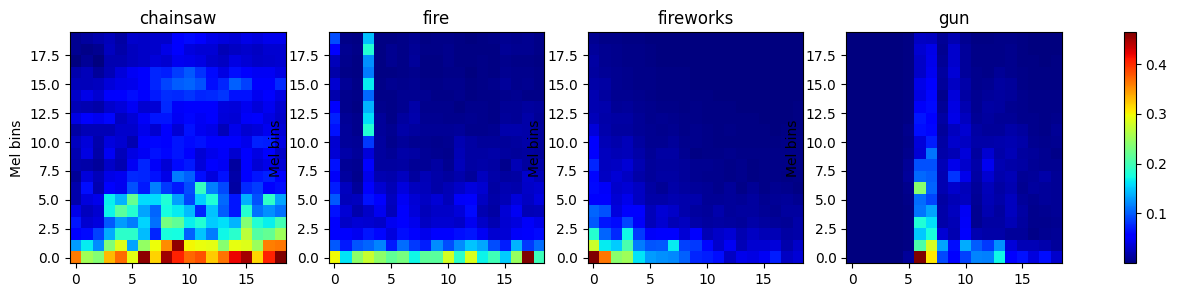

Number of shifts:  4
Number of bg_amplitude_limit and values:  3 [0.1, 0.1, 0.316]
X_aug shape:  (1280, 380)
Augmenting with time_shift
Shift number:  0
0/40
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
Shift number:  1
0/40
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
Shift number:  2
0/40
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
Shift number:  3
0/40
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19

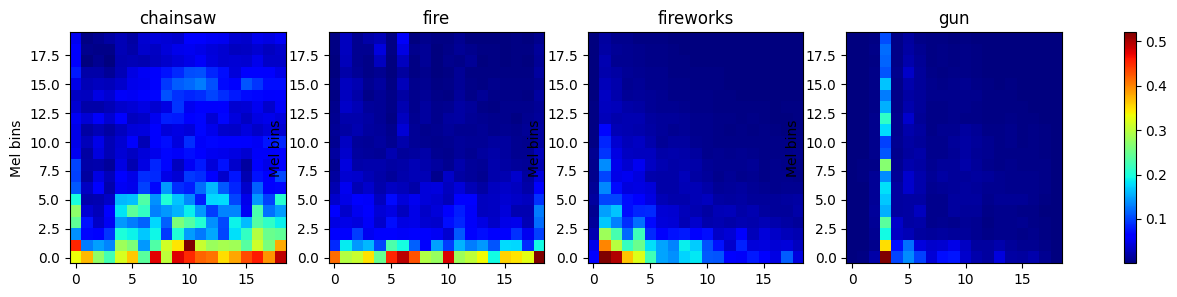

Plotting index: 810 (Aug: 5, Class: chainsaw, Img: 10)
Plotting index: 850 (Aug: 5, Class: fire, Img: 10)
Plotting index: 890 (Aug: 5, Class: fireworks, Img: 10)
Plotting index: 930 (Aug: 5, Class: gun, Img: 10)


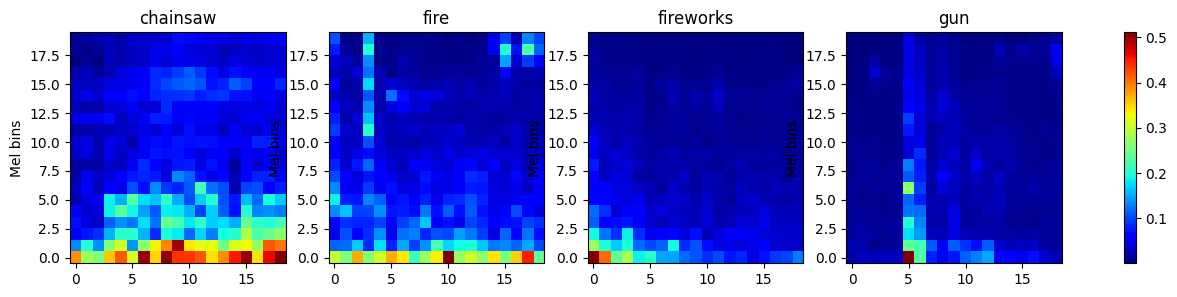

Plotting index: 970 (Aug: 6, Class: chainsaw, Img: 10)
Plotting index: 1010 (Aug: 6, Class: fire, Img: 10)
Plotting index: 1050 (Aug: 6, Class: fireworks, Img: 10)
Plotting index: 1090 (Aug: 6, Class: gun, Img: 10)


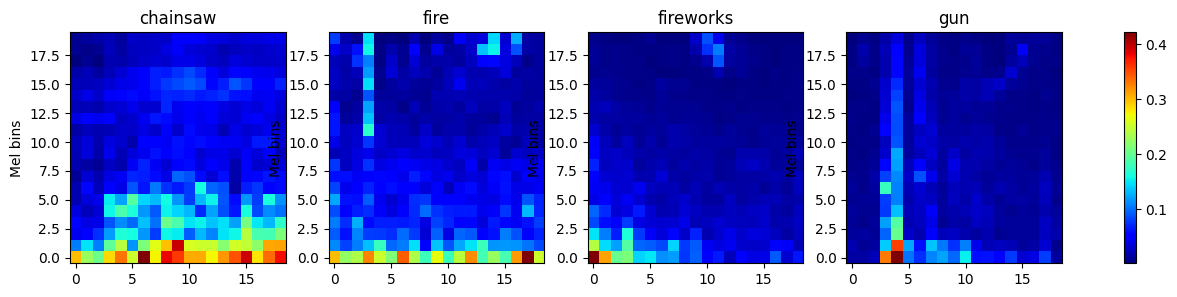

Plotting index: 1130 (Aug: 7, Class: chainsaw, Img: 10)
Plotting index: 1170 (Aug: 7, Class: fire, Img: 10)
Plotting index: 1210 (Aug: 7, Class: fireworks, Img: 10)
Plotting index: 1250 (Aug: 7, Class: gun, Img: 10)


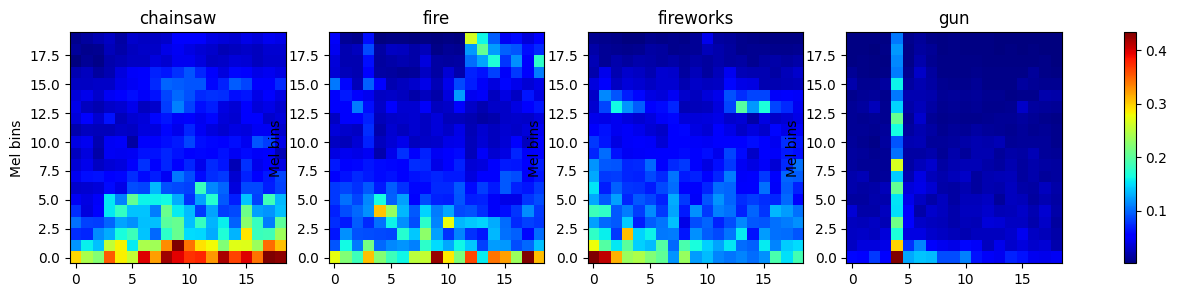

In [ ]:
#TODO: TO IMPROVE: data augmentation
#Idea: concatenate all sounds of the same class, and create much more instances by using shift
## + Sound analysis: if soud not loud enough, set its label to "garbage"
## Also garbage if only noise / ambiant sound

img_idx = 10
duration = 1000

#1. Import classical dataset - TO UPDATE FOR MCU RECORDINGS
myds, dataset, classnames = get_dataset(
    Nft=512, nmel=20, duration=duration, normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=False)

#3. Dataset augmentations - TO UPDATE
# original - 2 shifts - 1 bg: 16min
# original - 4 shifts - 1 bg: 26min

#CAREFUL: always time shift before add bg
augmentations = ["time_shift", "add_bg"]

shift_nb = 4
bg_amplitude_limit = [0.1,0.1,0.316] #0.1: 20dB, 0.316: 5dB

#define a pickle name corresponding to the number of shifts and background noises and length
pickle_name = f"../datasets/melvecs/original_{shift_nb}_shifts_{len(bg_amplitude_limit)}_backgrounds_{duration/1000}s.pkl"

if "time_shift" not in augmentations:
    shift_nb = 0
if "add_bg" not in augmentations:
    bg_amplitude_limit = []

# NORMALEMENT, la data augmentation doit être faite APRES le split train/test, mais demande de changer tt le code

#NEW: function spectro_aug_timefreq_masking

bg_dataset = Dataset(folder="../datasets/sounds/background")

X, y = augment_dataset(myds, dataset, classnames, augmentations, duration=duration,
                       shift_nb = shift_nb, #numbers of shifts done
                       bg_dataset = bg_dataset, bg_amplitude_limit=bg_amplitude_limit, #dataset used for background noise, background amplitudes
                       verbose=True, img_idx=img_idx, aug_indexes=[1,5,6,7], play_sound=False, #verbose parameters
                       load_matrix=False, pickle_name=pickle_name) #load and save parameters
                       
# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y = np.array([label_to_id[label] for label in y])

### 2. Data split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if (verbose):
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")


Shape of the training matrix : (896, 380)
Number of training labels : 896


### 3. Data preparation
Find if smthg to do here

### 5. Modelling

In [16]:


#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)


#D Self-made 1
def self_made_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = X_train.shape[1:]))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

    model.add(tf.keras.layers.Dense(units=hp_layer_1 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # ⚠️ Always create a fresh optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01]))

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



### 6. Training & 7. Evaluation

In [17]:
import keras_tuner as kt

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical

import pandas as pd
X_train = np.array(X_train, dtype=np.float32)
X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
X_train = X_train.fillna(0).values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers

def create_tuner(hypermodel):
    return kt.Hyperband(self_made_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_dir',
                     project_name='tuner1')


#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
tuner = create_tuner(hyperXception)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Reloading Tuner from hp_dir/tuner1/tuner0.json


In [18]:
from seaborn import heatmap

def show_confusion_matrix(y_predict, y_true, classnames, title=""):
    """
    From target labels and prediction arrays, sort them appropriately and plot confusion matrix.
    The arrays can contain either ints or str quantities, as long as classnames contains all the elements present in them.
    """
    plt.figure(figsize=(6, 6))  # Enlarged the figure size for better visibility
    
    # Compute confusion matrix
    confmat = confusion_matrix(y_true, y_predict)
    
    # Plot confusion matrix with enlarged annotations
    heatmap(
        confmat.T,
        square=True,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=classnames,
        yticklabels=classnames,
        annot_kws={"size": 14},  # Increase font size for annotations
        ax=plt.gca(),
    )
    
    # Set larger font sizes for labels and title
    plt.xlabel("True label", fontsize=16)
    plt.ylabel("Predicted label", fontsize=16)
    plt.title(title, fontsize=18)
    
    # Enlarge tick labels
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Display the plot
    plt.show()
    return None

def perform_kfold(model, X, y, k=5, epochs=5, batch_size=32):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores, recall_scores, f1_scores = [], [], []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        y_pred = np.argmax(model.predict(X_val), axis=1)
        y_true = y_val if len(y_val.shape) == 1 else np.argmax(y_val, axis=1)
        
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy_scores.append(report['accuracy'])
        recall_scores.append(report['macro avg']['recall'])
        f1_scores.append(report['macro avg']['f1-score'])
    
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.5f}")
    print(f"Mean Recall: {np.mean(recall_scores):.5f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.5f}")

def evaluate_model(model, X_train, y_train, X_test, y_test, classnames):
    model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)
    
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_train = y_train if len(y_train.shape) == 1 else np.argmax(y_train, axis=1)
    y_true_test = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)
    
    print("Training results:\n---------------------")
    print(f"Accuracy on train set: {np.mean(y_pred_train == y_true_train):.5f}")
    print(f"Accuracy on test set: {np.mean(y_pred_test == y_true_test):.5f}")
    
    print("Confusion Matrix (Train):")
    show_confusion_matrix(y_pred_train, y_true_train, classnames, title="Confusion Matrix - Train")
    print("Confusion Matrix (Test):")
    show_confusion_matrix(y_pred_test, y_true_test, classnames, title="Confusion Matrix - Test")
    
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, target_names=classnames))


### 8. Final model

/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3717 - loss: 1.3052 - val_accuracy: 0.5500 - val_loss: 1.0067
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6761 - loss: 0.8283 - val_accuracy: 0.6333 - val_loss: 0.8685
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7364 - loss: 0.6798 - val_accuracy: 0.7056 - val_loss: 0.7437
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7884 - loss: 0.5544 - val_accuracy: 0.7111 - val_loss: 0.7203
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8402 - loss: 0.4489 - val_accuracy: 0.7611 - val_loss: 0.6564
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8736 - loss: 0.3731 - val_accuracy: 0.7444 - val_loss: 0.7046
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9147 - loss: 0.2735 - val_accuracy: 0.7667 - val_loss: 0.7454
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9198 - loss: 0.2295 - val_accuracy: 0.7167 - v

/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Accuracy: 0.96434
Mean Recall: 0.96617
Mean F1-score: 0.96442
Epoch 1/5
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 0.0116

/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9786 - loss: 0.0553 - val_accuracy: 0.9333 - val_loss: 0.2012
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9626 - loss: 0.0926 - val_accuracy: 0.9500 - val_loss: 0.1155
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9915 - loss: 0.0369 - val_accuracy: 0.9611 - val_loss: 0.1035
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9967 - loss: 0.0147 - val_accuracy: 0.9611 - val_loss: 0.1546
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9899 - loss: 0.0529 - val_accuracy: 0.9500 - val_loss: 0.1459
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training results:
---------------------
Accuracy on train set: 0.98438
Accuracy on test set: 0.80990
Confusion Matrix (Train):


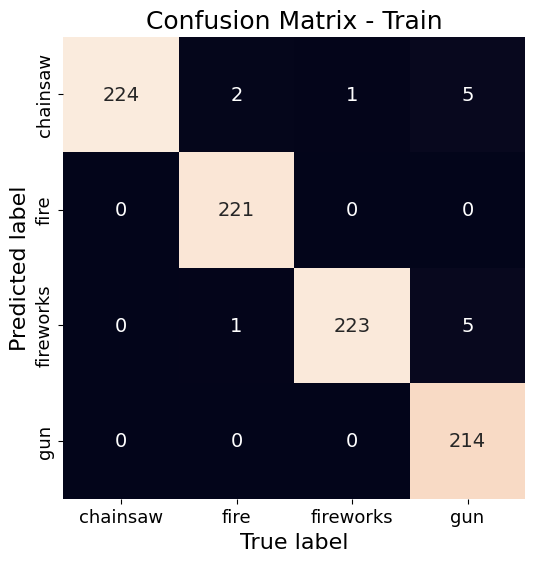

Confusion Matrix (Test):


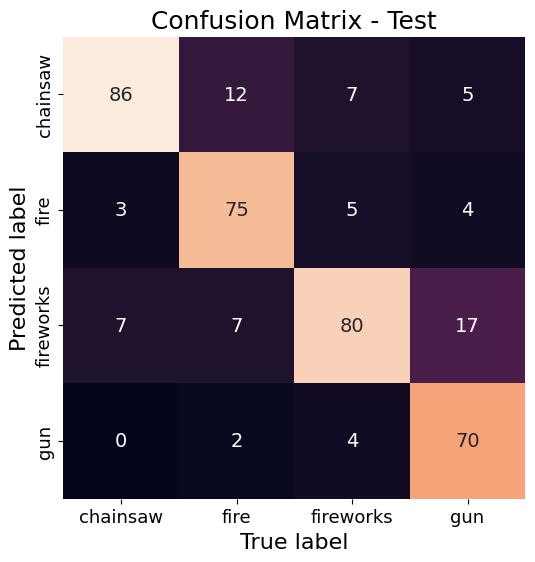


Classification Report:
              precision    recall  f1-score   support

    chainsaw       0.78      0.90      0.83        96
        fire       0.86      0.78      0.82        96
   fireworks       0.72      0.83      0.77        96
         gun       0.92      0.73      0.81        96

    accuracy                           0.81       384
   macro avg       0.82      0.81      0.81       384
weighted avg       0.82      0.81      0.81       384



[17:53:16] WARNING  You are saving your model as an HDF5 file via `model.save()` or                ]8;id=215974;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py\saving_api.py]8;;\:]8;id=728014;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py#83\83]8;;\
                    `keras.saving.save_model(model)`. This file format is considered legacy. We                    
                    recommend using instead the native Keras format, e.g.                                          
                    `model.save('my_model.keras')` or `keras.saving.save_model(model,                              
                    'my_model.keras')`.                                                                            

In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


#8. Final_model
#TODO: perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)


predictions = hypermodel.predict(X_test)

eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

# Perform K-Fold cross-validation
perform_kfold(model, X_train, y_train, k=5, epochs=5)

# Train and evaluate final model
evaluate_model(model, X_train, y_train, X_test, y_test, classnames)

model.save('../../models/original_2shifts_1bg.h5')  # Saves in HDF5 format